In [361]:
import pandas as pd
tekme_redne = pd.read_csv('statistika-v-csv/tekme_redne.csv', index_col='Tekma',encoding = "utf-8")
tekme_playoff = pd.read_csv('statistika-v-csv/tekme_playoff.csv', index_col='Tekma',encoding = "utf-8")
ekipe = pd.read_csv('statistika-v-csv/ekipe.csv', index_col='Team',encoding = "utf-8")
pd.options.display.max_rows = 10
%matplotlib inline

In [362]:
tekme_redne = tekme_redne[tekme_redne.Team != 31] #izbrišemo All-Star tekmo
tekme_redne = tekme_redne[tekme_redne.Team != 32]
ekipe = ekipe.drop([31,32]) #izbrišemo All-Star ekipi
tekme_redne[["FGM", "FGA"]] = tekme_redne["FG"].str.split("-", expand = True)
tekme_redne[["3PM", "3PA"]] = tekme_redne["3PT"].str.split("-", expand = True)
tekme_redne[["FTM", "FTA"]] = tekme_redne["FT"].str.split("-", expand = True)
tekme_playoff[["FGM", "FGA"]] = tekme_playoff["FG"].str.split("-", expand = True)
tekme_playoff[["3PM", "3PA"]] = tekme_playoff["3PT"].str.split("-", expand = True)
tekme_playoff[["FTM", "FTA"]] = tekme_playoff["FT"].str.split("-", expand = True)
tekme_redne = tekme_redne.drop(columns=['FG','3PT','FT'])
tekme_playoff = tekme_playoff.drop(columns=['FG','3PT','FT'])


In [363]:
tekme_redne = tekme_redne.astype(float)
tekme_playoff = tekme_playoff.astype(float)
tekme_redne["Team"] = tekme_redne["Team"].astype(int)
tekme_playoff["Team"] = tekme_playoff["Team"].astype(int)

In [364]:
expected_value = 1.06
tekme_redne["FG%"] = 100 * tekme_redne["FGM"]/tekme_redne["FGA"]
tekme_redne["3P%"] = 100 * tekme_redne["3PM"]/tekme_redne["3PA"]
tekme_redne["FT%"] = 100 * tekme_redne["FTM"]/tekme_redne["FTA"]
tekme_redne["3NG"] = 3 * ((3 - expected_value) * tekme_redne["3PM"] - expected_value * (tekme_redne["3PA"] - tekme_redne["3PM"]))
tekme_playoff["FG%"] = 100 * tekme_playoff["FGM"]/tekme_playoff["FGA"]
tekme_playoff["3P%"] = 100 * tekme_playoff["3PM"]/tekme_playoff["3PA"]
tekme_playoff["FT%"] = 100 * tekme_playoff["FTM"]/tekme_playoff["FTA"]
tekme_playoff["3NG"] = 3 * ((3 - expected_value) * tekme_playoff["3PM"] - expected_value * (tekme_playoff["3PA"] - tekme_playoff["3PM"]))

In [365]:
tekme_redne["FG%"] = tekme_redne["FG%"].round(decimals=2)
tekme_redne["3P%"] = tekme_redne["3P%"].round(decimals=2)
tekme_redne["FT%"] = tekme_redne["FT%"].round(decimals=2)
tekme_playoff["FG%"] = tekme_playoff["FG%"].round(decimals=2)
tekme_playoff["3P%"] = tekme_playoff["3P%"].round(decimals=2)
tekme_playoff["FT%"] = tekme_playoff["FT%"].round(decimals=2)

In [366]:
zmaga_poraz_redne = []

for i in range(tekme_redne["PTS"].size):
    if i % 2 == 0:
        if tekme_redne["PTS"].iloc[i] > tekme_redne["PTS"].iloc[i + 1]:
            zmaga_poraz_redne.append(1)
        else:
            zmaga_poraz_redne.append(0)
    else:
        if tekme_redne["PTS"].iloc[i] > tekme_redne["PTS"].iloc[i - 1]:
            zmaga_poraz_redne.append(1)
        else:
            zmaga_poraz_redne.append(0)

tekme_redne["W/L"] = zmaga_poraz_redne

zmaga_poraz_playoff = []

for i in range(tekme_playoff["PTS"].size):
    if i % 2 == 0:
        if tekme_playoff["PTS"].iloc[i] > tekme_playoff["PTS"].iloc[i + 1]:
            zmaga_poraz_playoff.append(1)
        else:
            zmaga_poraz_playoff.append(0)
    else:
        if tekme_playoff["PTS"].iloc[i] > tekme_playoff["PTS"].iloc[i - 1]:
            zmaga_poraz_playoff.append(1)
        else:
            zmaga_poraz_playoff.append(0)

tekme_playoff["W/L"] = zmaga_poraz_playoff

In [367]:
ekipe_redno_2 = tekme_redne.groupby("Team")
ekipe_playoff_2 = tekme_playoff.groupby("Team")
ekipe_redno = ekipe_redno_2.sum()
ekipe_playoff = ekipe_playoff_2.sum()

In [368]:
ekipe_redno["FG%"] = ekipe_redno["FG%"]/ekipe_redno_2.count()["FG%"]
ekipe_redno["3P%"] = ekipe_redno["3P%"]/ekipe_redno_2.count()["3P%"]
ekipe_redno["FT%"] = ekipe_redno["FT%"]/ekipe_redno_2.count()["FT%"]
ekipe_redno["3NG"] = 3 * ((3 - expected_value) * ekipe_redno["3PM"] - expected_value * (ekipe_redno["3PA"] - ekipe_redno["3PM"]))
ekipe_playoff["FG%"] = ekipe_playoff["FG%"]/ekipe_playoff_2.count()["FG%"]
ekipe_playoff["3P%"] = ekipe_playoff["3P%"]/ekipe_playoff_2.count()["3P%"]
ekipe_playoff["FT%"] = ekipe_playoff["FT%"]/ekipe_playoff_2.count()["FT%"]
ekipe_redno["3PA/FGA"] = ekipe_redno["3PA"]/ekipe_redno["FGA"]
ekipe_playoff["3PA/FGA"] = ekipe_playoff["3PA"]/ekipe_playoff["FGA"]
ekipe_playoff["3NG"] = 3 * ((3 - expected_value) * ekipe_playoff["3PM"] - expected_value * (ekipe_playoff["3PA"] - ekipe_playoff["3PM"]))

In [369]:
ekipe_redno = ekipe_redno.rename(columns={"W/L" : "WINS"})
ekipe_playoff = ekipe_playoff.rename(columns={"W/L" : "WINS"})
ekipe_redno["WIN%"] = 100 * ekipe_redno["WINS"]/ekipe_redno_2.count()["W/L"]
ekipe_playoff["WIN%"] = 100 * ekipe_playoff["WINS"]/ekipe_playoff_2.count()["W/L"]

In [370]:
lestvica_redno = pd.merge(ekipe, ekipe_redno, left_index=True, right_index=True)
lestvica_redno = lestvica_redno.sort_values(by='WIN%',ascending=False)
najvec_relativno_za_tri_redno = pd.merge(ekipe, ekipe_redno, left_index=True, right_index=True)
najvec_relativno_za_tri_redno = najvec_relativno_za_tri_redno.sort_values(by='3PA/FGA',ascending=False)
najuspesneje_za_tri = pd.merge(ekipe, ekipe_redno, left_index=True, right_index=True)
najuspesneje_za_tri = najuspesneje_za_tri.sort_values(by='3P%',ascending=False)
najboljsi_3NG = pd.merge(ekipe, ekipe_redno, left_index=True, right_index=True)
najboljsi_3NG = najboljsi_3NG.sort_values(by='3P%',ascending=False)

In [371]:
lestvica_redno

,Name,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,...,3PA,FTM,FTA,FG%,3P%,FT%,3NG,WINS,3PA/FGA,WIN%
Team,,,,,,,,,,,,,,,,,,,,,
23,UTAH,765.0,2708.0,3473.0,1703.0,475.0,370.0,973.0,1335.0,8382.0,...,3098.0,1235.0,1546.0,46.914167,38.772917,79.325139,993.36,52,0.488335,72.222222
27,PHX,613.0,2380.0,2993.0,1882.0,505.0,298.0,838.0,1335.0,8071.0,...,2425.0,1101.0,1316.0,49.142429,37.759000,83.673714,532.50,49,0.392840,70.000000
12,PHI,722.0,2521.0,3243.0,1706.0,655.0,447.0,988.0,1456.0,8182.0,...,2169.0,1409.0,1836.0,47.688611,37.599444,76.752778,401.58,49,0.346652,68.055556
22,DEN,749.0,2419.0,3168.0,1908.0,575.0,322.0,910.0,1354.0,8176.0,...,2426.0,1106.0,1375.0,48.666197,37.876901,80.862958,529.32,47,0.382589,66.197183
2,BKN,620.0,2479.0,3099.0,1877.0,471.0,365.0,910.0,1327.0,8287.0,...,2535.0,1259.0,1568.0,49.445143,38.684429,80.265143,848.70,46,0.414013,65.714286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,CLE,751.0,2328.0,3079.0,1716.0,559.0,325.0,1039.0,1308.0,7476.0,...,2142.0,1200.0,1614.0,45.044028,33.663194,74.271250,-331.56,22,0.346826,30.555556
25,OKC,705.0,2531.0,3236.0,1556.0,496.0,316.0,1095.0,1291.0,7446.0,...,2493.0,1104.0,1520.0,44.150423,33.838732,72.642113,-349.74,21,0.399263,29.577465
10,ORL,746.0,2527.0,3273.0,1572.0,495.0,320.0,882.0,1235.0,7488.0,...,2287.0,1196.0,1543.0,42.935556,33.912361,77.584444,-216.66,21,0.356175,29.166667


In [372]:
najvec_relativno_za_tri_redno

,Name,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,...,3PA,FTM,FTA,FG%,3P%,FT%,3NG,WINS,3PA/FGA,WIN%
Team,,,,,,,,,,,,,,,,,,,,,
23,UTAH,765.0,2708.0,3473.0,1703.0,475.0,370.0,973.0,1335.0,8382.0,...,3098.0,1235.0,1546.0,46.914167,38.772917,79.325139,993.36,52,0.488335,72.222222
26,HOU,671.0,2396.0,3067.0,1699.0,546.0,362.0,1026.0,1407.0,7833.0,...,2923.0,1189.0,1606.0,44.414583,33.865972,74.110694,-367.14,17,0.458798,23.611111
24,POR,766.0,2441.0,3207.0,1531.0,496.0,364.0,775.0,1363.0,8360.0,...,2939.0,1282.0,1558.0,45.453611,38.602917,82.074583,841.98,42,0.448155,58.333333
14,TOR,641.0,2227.0,2868.0,1678.0,597.0,377.0,862.0,1475.0,7680.0,...,2723.0,1186.0,1455.0,45.011594,36.947246,81.301594,394.86,27,0.445590,39.130435
1,GS,563.0,2491.0,3054.0,1977.0,583.0,336.0,1043.0,1504.0,8088.0,...,2745.0,1172.0,1495.0,47.086338,37.625493,78.209437,612.90,39,0.439270,54.929577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,PHI,722.0,2521.0,3243.0,1706.0,655.0,447.0,988.0,1456.0,8182.0,...,2169.0,1409.0,1836.0,47.688611,37.599444,76.752778,401.58,49,0.346652,68.055556
18,MEM,802.0,2544.0,3346.0,1938.0,655.0,364.0,916.0,1349.0,8157.0,...,2258.0,1184.0,1536.0,46.711111,35.479167,77.696667,46.56,38,0.341759,52.777778
13,NO,834.0,2538.0,3372.0,1854.0,537.0,313.0,984.0,1275.0,8153.0,...,2155.0,1343.0,1845.0,47.988310,34.775352,72.622535,-84.90,31,0.340227,43.661972


In [373]:
najuspesneje_za_tri

,Name,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,...,3PA,FTM,FTA,FG%,3P%,FT%,3NG,WINS,3PA/FGA,WIN%
Team,,,,,,,,,,,,,,,,,,,,,
3,LAC,669.0,2473.0,3142.0,1724.0,500.0,291.0,877.0,1351.0,8088.0,...,2459.0,1144.0,1363.0,48.213944,41.164085,83.892254,1252.38,46,0.398671,64.788732
7,NY,697.0,2554.0,3251.0,1541.0,507.0,365.0,875.0,1473.0,7706.0,...,2163.0,1181.0,1506.0,45.657222,39.133611,78.591528,744.66,41,0.347358,56.944444
23,UTAH,765.0,2708.0,3473.0,1703.0,475.0,370.0,973.0,1335.0,8382.0,...,3098.0,1235.0,1546.0,46.914167,38.772917,79.325139,993.36,52,0.488335,72.222222
2,BKN,620.0,2479.0,3099.0,1877.0,471.0,365.0,910.0,1327.0,8287.0,...,2535.0,1259.0,1568.0,49.445143,38.684429,80.265143,848.70,46,0.414013,65.714286
24,POR,766.0,2441.0,3207.0,1531.0,496.0,364.0,775.0,1363.0,8360.0,...,2939.0,1282.0,1558.0,45.453611,38.602917,82.074583,841.98,42,0.448155,58.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,SA,659.0,2454.0,3113.0,1729.0,500.0,361.0,781.0,1285.0,7877.0,...,2023.0,1240.0,1565.0,46.191408,34.735634,79.381972,-52.14,33,0.315060,46.478873
10,ORL,746.0,2527.0,3273.0,1572.0,495.0,320.0,882.0,1235.0,7488.0,...,2287.0,1196.0,1543.0,42.935556,33.912361,77.584444,-216.66,21,0.356175,29.166667
26,HOU,671.0,2396.0,3067.0,1699.0,546.0,362.0,1026.0,1407.0,7833.0,...,2923.0,1189.0,1606.0,44.414583,33.865972,74.110694,-367.14,17,0.458798,23.611111


In [374]:
najboljsi_3NG

,Name,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,...,3PA,FTM,FTA,FG%,3P%,FT%,3NG,WINS,3PA/FGA,WIN%
Team,,,,,,,,,,,,,,,,,,,,,
3,LAC,669.0,2473.0,3142.0,1724.0,500.0,291.0,877.0,1351.0,8088.0,...,2459.0,1144.0,1363.0,48.213944,41.164085,83.892254,1252.38,46,0.398671,64.788732
7,NY,697.0,2554.0,3251.0,1541.0,507.0,365.0,875.0,1473.0,7706.0,...,2163.0,1181.0,1506.0,45.657222,39.133611,78.591528,744.66,41,0.347358,56.944444
23,UTAH,765.0,2708.0,3473.0,1703.0,475.0,370.0,973.0,1335.0,8382.0,...,3098.0,1235.0,1546.0,46.914167,38.772917,79.325139,993.36,52,0.488335,72.222222
2,BKN,620.0,2479.0,3099.0,1877.0,471.0,365.0,910.0,1327.0,8287.0,...,2535.0,1259.0,1568.0,49.445143,38.684429,80.265143,848.70,46,0.414013,65.714286
24,POR,766.0,2441.0,3207.0,1531.0,496.0,364.0,775.0,1363.0,8360.0,...,2939.0,1282.0,1558.0,45.453611,38.602917,82.074583,841.98,42,0.448155,58.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,SA,659.0,2454.0,3113.0,1729.0,500.0,361.0,781.0,1285.0,7877.0,...,2023.0,1240.0,1565.0,46.191408,34.735634,79.381972,-52.14,33,0.315060,46.478873
10,ORL,746.0,2527.0,3273.0,1572.0,495.0,320.0,882.0,1235.0,7488.0,...,2287.0,1196.0,1543.0,42.935556,33.912361,77.584444,-216.66,21,0.356175,29.166667
26,HOU,671.0,2396.0,3067.0,1699.0,546.0,362.0,1026.0,1407.0,7833.0,...,2923.0,1189.0,1606.0,44.414583,33.865972,74.110694,-367.14,17,0.458798,23.611111


<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Razmerje metov za tri in vseh metov na koš', ylabel='Delež zmag izmed vseh tekem [%]'>

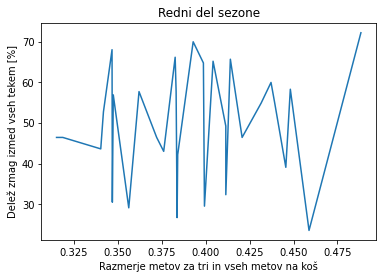

In [375]:
lestvica_redno.groupby("3PA/FGA")["WIN%"].mean().plot(title = "Redni del sezone", xlabel="Razmerje metov za tri in vseh metov na koš", ylabel="Delež zmag izmed vseh tekem [%]")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Število vseh metov za tri', ylabel='Delež zmag izmed vseh tekem [%]'>

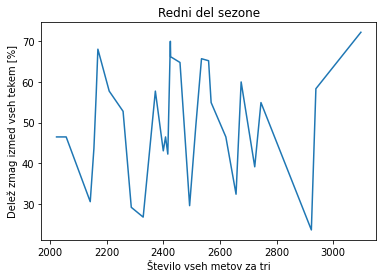

In [376]:
lestvica_redno.groupby("3PA")["WIN%"].mean().plot(title = "Redni del sezone", xlabel="Število vseh metov za tri", ylabel="Delež zmag izmed vseh tekem [%]")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Uspešnost meta za tri [%]', ylabel='Delež zmag izmed vseh tekem [%]'>

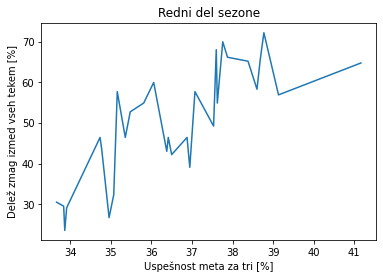

In [377]:
lestvica_redno.groupby("3P%")["WIN%"].mean().plot(title = "Redni del sezone", xlabel="Uspešnost meta za tri [%]", ylabel="Delež zmag izmed vseh tekem [%]")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='3NG koeficient', ylabel='Delež zmag izmed vseh tekem [%]'>

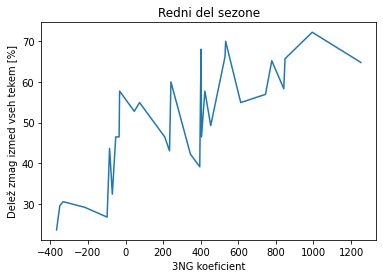

In [378]:
ekipe_redno.groupby("3NG")["WIN%"].mean().plot(title = "Redni del sezone", xlabel="3NG koeficient", ylabel="Delež zmag izmed vseh tekem [%]")

In [379]:
razlika_v_tockah = []
razlika_v_delezu_meta_za_tri = []
povprecje_meta_za_tri = []
razlika_v_metu_za_tri = []
razlika_v_metu_za_tri_sezona = []
razlika_3NG = []

for i in range(tekme_redne["3P%"].size//2):
    razlika_v_delezu_meta_za_tri.append(tekme_redne["3P%"].iloc[2 * i] - tekme_redne["3P%"].iloc[2 * i + 1])
    razlika_v_metu_za_tri.append(100* (tekme_redne["3PA"].iloc[2 * i]/tekme_redne["FGA"].iloc[2 * i] - tekme_redne["3PA"].iloc[2 * i + 1]/tekme_redne["FGA"].iloc[2 * i + 1]))
    razlika_v_tockah.append(tekme_redne["PTS"].iloc[2 * i] - tekme_redne["PTS"].iloc[2 * i + 1])
    razlika_v_delezu_meta_za_tri.append(tekme_redne["3P%"].iloc[2 * i + 1] - tekme_redne["3P%"].iloc[2 * i])
    razlika_v_metu_za_tri.append(100* (tekme_redne["3PA"].iloc[2 * i + 1]/tekme_redne["FGA"].iloc[2 * i + 1] - tekme_redne["3PA"].iloc[2 * i]/tekme_redne["FGA"].iloc[2 * i]))
    razlika_v_tockah.append(tekme_redne["PTS"].iloc[2 * i + 1] - tekme_redne["PTS"].iloc[2 * i])
    prva_ekipa = tekme_redne["Team"].iloc[2 * i]
    druga_ekipa = tekme_redne["Team"].iloc[2 * i + 1]
    razlika_v_metu_za_tri_sezona.append(ekipe_redno["3P%"].loc[prva_ekipa] - ekipe_redno["3P%"].loc[druga_ekipa])
    razlika_v_metu_za_tri_sezona.append(ekipe_redno["3P%"].loc[druga_ekipa] - ekipe_redno["3P%"].loc[prva_ekipa])
    razlika_3NG.append(tekme_redne["3NG"].iloc[2 * i] - tekme_redne["3NG"].iloc[2 * i + 1])
    razlika_3NG.append(tekme_redne["3NG"].iloc[2 * i + 1] - tekme_redne["3NG"].iloc[2 * i])
    povprecje_meta_za_tri.extend(2 * [(tekme_redne["3P%"].iloc[2 * i + 1] + tekme_redne["3P%"].iloc[2 * i])/2])

data = {"PTS DIFF" : razlika_v_tockah, "3P% DIFF": razlika_v_delezu_meta_za_tri, "3P% DIFF SEASON" : razlika_v_metu_za_tri_sezona, "3PA/FGA DIFF" : razlika_v_metu_za_tri,
        "3NG DIFF" : razlika_3NG, "3P% AVG" : povprecje_meta_za_tri}
tekme_redne2 = pd.DataFrame(data)
tekme_redne2 = tekme_redne2.rename_axis(index="Tekma")

razlika_v_tockah = []
razlika_v_delezu_meta_za_tri = []
povprecje_meta_za_tri = []
razlika_v_metu_za_tri = []
razlika_v_metu_za_tri_sezona = []
razlika_3NG = []

for i in range(tekme_playoff["3P%"].size//2):
    razlika_v_delezu_meta_za_tri.append(tekme_playoff["3P%"].iloc[2 * i] - tekme_playoff["3P%"].iloc[2 * i + 1])
    razlika_v_metu_za_tri.append(100* (tekme_playoff["3PA"].iloc[2 * i]/tekme_playoff["FGA"].iloc[2 * i] - tekme_playoff["3PA"].iloc[2 * i + 1]/tekme_playoff["FGA"].iloc[2 * i + 1]))
    razlika_v_delezu_meta_za_tri.append(tekme_playoff["3P%"].iloc[2 * i + 1] - tekme_playoff["3P%"].iloc[2 * i])
    razlika_v_metu_za_tri.append(100* (tekme_playoff["3PA"].iloc[2 * i + 1]/tekme_playoff["FGA"].iloc[2 * i + 1] - tekme_playoff["3PA"].iloc[2 * i]/tekme_playoff["FGA"].iloc[2 * i]))
    razlika_v_tockah.append(abs(tekme_playoff["PTS"].iloc[2 * i] - tekme_playoff["PTS"].iloc[2 * i + 1]))
    razlika_v_tockah.append(abs(tekme_playoff["PTS"].iloc[2 * i + 1] - tekme_playoff["PTS"].iloc[2 * i]))
    prva_ekipa = tekme_playoff["Team"].iloc[2 * i]
    druga_ekipa = tekme_playoff["Team"].iloc[2 * i + 1]
    razlika_v_metu_za_tri_sezona.append(ekipe_playoff["3P%"].loc[prva_ekipa] - ekipe_playoff["3P%"].loc[druga_ekipa])
    razlika_v_metu_za_tri_sezona.append(ekipe_playoff["3P%"].loc[druga_ekipa] - ekipe_playoff["3P%"].loc[prva_ekipa])
    razlika_3NG.append(tekme_playoff["3NG"].iloc[2 * i] - tekme_playoff["3NG"].iloc[2 * i + 1])
    razlika_3NG.append(tekme_playoff["3NG"].iloc[2 * i + 1] - tekme_playoff["3NG"].iloc[2 * i])
    povprecje_meta_za_tri.extend(2 * [(tekme_playoff["3P%"].iloc[2 * i + 1] + tekme_playoff["3P%"].iloc[2 * i])/2])

data = {"PTS DIFF" : razlika_v_tockah, "3P% DIFF": razlika_v_delezu_meta_za_tri, "3P% DIFF SEASON" : razlika_v_metu_za_tri_sezona, "3PA/FGA DIFF" : razlika_v_metu_za_tri,
        "3NG DIFF" : razlika_3NG, "3P% AVG" : povprecje_meta_za_tri}
tekme_playoff2 = pd.DataFrame(data)
tekme_playoff2 = tekme_playoff2.rename_axis(index="Tekma")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Razlika v uspešnosti meta za tri glede na nasprotno ekipo [%]', ylabel='Razlika v doseženih točkah glede na nasprotno ekipo'>

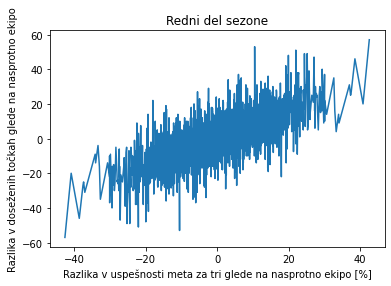

In [380]:
tekme_redne2.groupby("3P% DIFF")["PTS DIFF"].mean().plot(title="Redni del sezone", xlabel="Razlika v uspešnosti meta za tri glede na nasprotno ekipo [%]", ylabel="Razlika v doseženih točkah glede na nasprotno ekipo")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Razlika v uspešnosti meta za tri med zmagovalcem in poražencem [%]', ylabel='Razlika v doseženih točkah glede na nasprotno ekipo'>

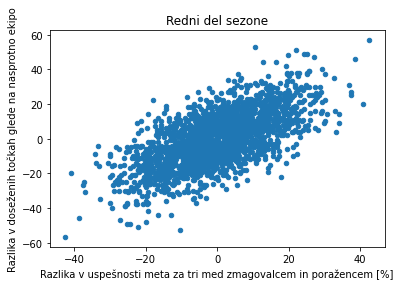

In [381]:
tekme_redne2.plot.scatter("3P% DIFF","PTS DIFF",title="Redni del sezone", xlabel="Razlika v uspešnosti meta za tri med zmagovalcem in poražencem [%]", ylabel="Razlika v doseženih točkah glede na nasprotno ekipo")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Razlika v deležu meta za tri izmed vseh metov glede na nasprotno ekipo [%]', ylabel='Razlika v doseženih točkah glede na nasprotno ekipo'>

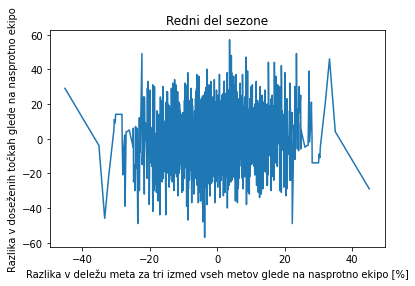

In [382]:
tekme_redne2.groupby("3PA/FGA DIFF")["PTS DIFF"].mean().plot(title="Redni del sezone", xlabel="Razlika v deležu meta za tri izmed vseh metov glede na nasprotno ekipo [%]", ylabel="Razlika v doseženih točkah glede na nasprotno ekipo")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Razlika v deležu meta za tri izmed vseh metov glede na nasprotno ekipo [%]', ylabel='Razlika v doseženih točkah glede na nasprotno ekipo'>

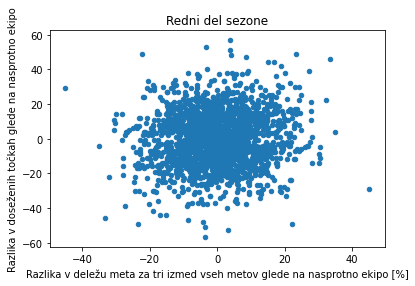

In [383]:
tekme_redne2.plot.scatter("3PA/FGA DIFF", "PTS DIFF",title="Redni del sezone", xlabel="Razlika v deležu meta za tri izmed vseh metov glede na nasprotno ekipo [%]", ylabel="Razlika v doseženih točkah glede na nasprotno ekipo")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Razlika v uspešnosti meta za tri glede na nasprotno ekipo skozi celotno sezono [%]', ylabel='Razlika v doseženih točkah glede na nasprotno ekipo'>

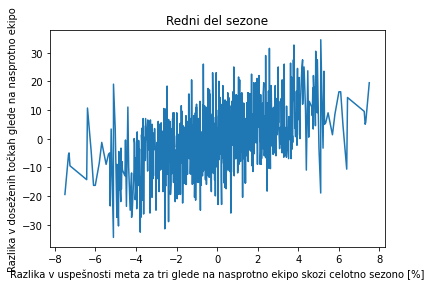

In [384]:
tekme_redne2.groupby("3P% DIFF SEASON")["PTS DIFF"].mean().plot(title="Redni del sezone", xlabel="Razlika v uspešnosti meta za tri glede na nasprotno ekipo skozi celotno sezono [%]", ylabel="Razlika v doseženih točkah glede na nasprotno ekipo")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Razlika v uspešnosti meta za tri glede na nasprotno ekipo skozi celotno sezono [%]', ylabel='Razlika v doseženih točkah glede na nasprotno ekipo'>

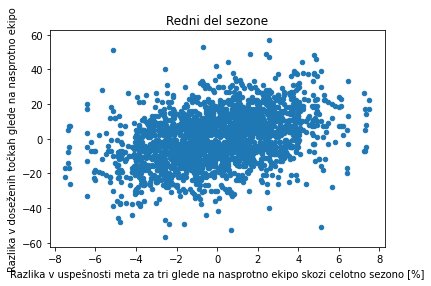

In [385]:
tekme_redne2.plot.scatter("3P% DIFF SEASON", "PTS DIFF", title="Redni del sezone", xlabel="Razlika v uspešnosti meta za tri glede na nasprotno ekipo skozi celotno sezono [%]", ylabel="Razlika v doseženih točkah glede na nasprotno ekipo")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Razlika v 3NG koeficientu glede na nasprotno ekipo', ylabel='Razlika v doseženih točkah glede na nasprotno ekipo'>

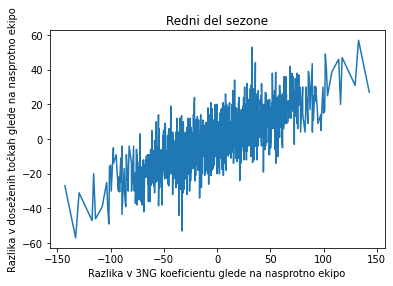

In [386]:
tekme_redne2.groupby("3NG DIFF")["PTS DIFF"].mean().plot(title="Redni del sezone", xlabel="Razlika v 3NG koeficientu glede na nasprotno ekipo", ylabel="Razlika v doseženih točkah glede na nasprotno ekipo")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Razlika v 3NG koeficientu glede na nasprotno ekipo', ylabel='Razlika v doseženih točkah glede na nasprotno ekipo'>

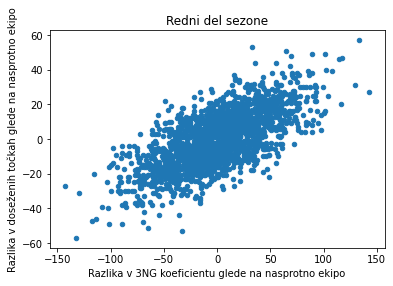

In [387]:
tekme_redne2.plot.scatter("3NG DIFF","PTS DIFF",title="Redni del sezone", xlabel="Razlika v 3NG koeficientu glede na nasprotno ekipo", ylabel="Razlika v doseženih točkah glede na nasprotno ekipo")

Opazimo, da je graf odvisnosti razlike v točkah od koeficienta 3NG rahlo strmejši od grafa, ki ponazarja odvisnost razlike v točkah od uspešnosti meta. To nas lahko navede do razmišljanja, da je večji 3NG boljši kot uspešnejši met. Pri konstanti uspešnosti meta, 3NG ne bo konstanten, temveč se bo spreminjal glede na število metov za tri. Odvisnost 3NG od uspešnih in vseh metov za tri je prikazana na spodnjem grafu, na katerem je tudi jasno razvidno, da bo pri npr. 100% metu za tri točke 3NG naraščal s številom metov.

In [388]:
vrednosti_3NG = [[],[],[]]

for i in range(100):
    for j in range(i,100):
        vrednosti_3NG[0].append(i)
        vrednosti_3NG[1].append(j)
        vrednosti_3NG[2].append(3 * ((3 - expected_value) * i - expected_value * (j - i)))

data = {"3PM" : vrednosti_3NG[0], "3PA" : vrednosti_3NG[1], "3NG" : vrednosti_3NG[2]}
graf_3NG = pd.DataFrame(data)

C:\Users\mkocb\AppData\Local\Temp/ipykernel_7936/2154685817.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  threedee = plt.figure().gca(projection='3d')


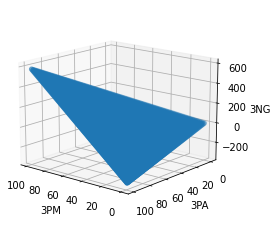

In [389]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

threedee = plt.figure().gca(projection='3d')
threedee.scatter(graf_3NG["3PM"], graf_3NG["3PA"], graf_3NG['3NG'])
threedee.set_xlabel('3PM')
threedee.set_ylabel('3PA')
threedee.set_zlabel('3NG')
threedee.view_init(15,130)
plt.show()

Prejšnji komentar glede 3NG nam, da idejo, da primerjamo ekipe, ki so približno enako uspešno metale za tri in pogledamo, kako je med njimi bilo pomembno število metov za tri točke. Naslednji graf prikazuje razlike v točkah na posameznih tekmah med ekipama, ki sta na tej tekmi približno enako dobro metali za tri, v odvisnosti od tega, kako veliko so ekipe metale za tri in kakšna je bila povprečna uspešnost meta za tri obeh ekip.

C:\Users\mkocb\AppData\Local\Temp/ipykernel_7936/2073699131.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  threedee = plt.figure().gca(projection='3d')


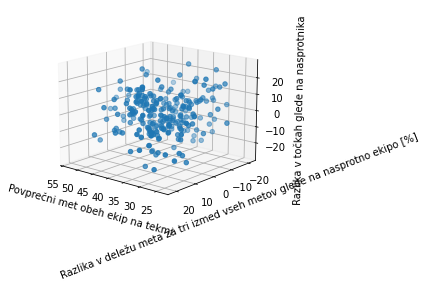

In [390]:
priblizno_enakovredne_tekme = tekme_redne2[abs(tekme_redne2["3P% DIFF"]) < 2]
threedee = plt.figure().gca(projection='3d')
threedee.scatter(priblizno_enakovredne_tekme["3P% AVG"], priblizno_enakovredne_tekme["3PA/FGA DIFF"], priblizno_enakovredne_tekme['PTS DIFF'])
threedee.set_xlabel('Povprečni met obeh ekip na tekmi')
threedee.set_ylabel('Razlika v deležu meta za tri izmed vseh metov glede na nasprotno ekipo [%]')
threedee.set_zlabel('Razlika v točkah glede na nasprotnika')
threedee.view_init(15,130)
plt.show()

Ker je ta 3D graf precej nepregleden, poglejmo 2D grafe za posamezne vrednost povprečnih metov obeh ekip.

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Razlika v deležu meta za tri izmed vseh metov glede na nasprotno ekipo [%]', ylabel='Razlika v doseženih točkah glede na nasprotno ekipo'>

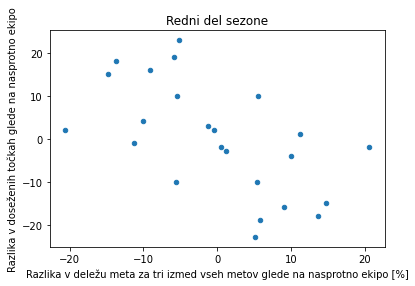

In [391]:
priblizno_enakovredne_tekme = tekme_redne2[(abs(tekme_redne2["3P% DIFF"]) < 2) & ((tekme_redne2["3P% AVG"] >= 25) & (tekme_redne2["3P% AVG"] <= 30))]
priblizno_enakovredne_tekme.plot.scatter("3PA/FGA DIFF","PTS DIFF",title="Redni del sezone", xlabel="Razlika v deležu meta za tri izmed vseh metov glede na nasprotno ekipo [%]", ylabel="Razlika v doseženih točkah glede na nasprotno ekipo")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Razlika v deležu meta za tri izmed vseh metov glede na nasprotno ekipo [%]', ylabel='Razlika v doseženih točkah glede na nasprotno ekipo'>

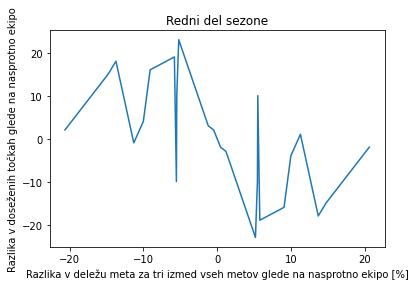

In [392]:
priblizno_enakovredne_tekme.groupby("3PA/FGA DIFF")["PTS DIFF"].mean().plot(title="Redni del sezone", xlabel="Razlika v deležu meta za tri izmed vseh metov glede na nasprotno ekipo [%]", ylabel="Razlika v doseženih točkah glede na nasprotno ekipo")

Opazimo, da graf pokaže, da so na tekmah, kjer sta obe ekipi metali približno enako slabo za tri, praviloma izgubljale ekipe, ki so več metale za tri. Če pa pogledamo naslednje grafe, ki prikazujejo tekme, na katerih so ekipe za tri metale približno enako dobro in ne pretirano slabo, vidimo, da prejšnjega pravila več ne moremo zaslediti.

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Razlika v deležu meta za tri izmed vseh metov glede na nasprotno ekipo [%]', ylabel='Razlika v doseženih točkah glede na nasprotno ekipo'>

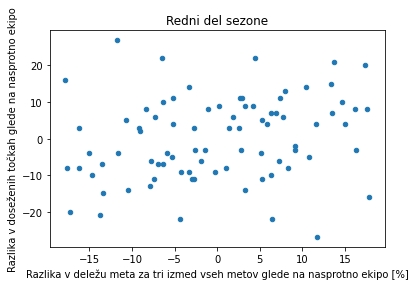

In [393]:
priblizno_enakovredne_tekme = tekme_redne2[(abs(tekme_redne2["3P% DIFF"]) < 2) & ((tekme_redne2["3P% AVG"] >= 35) & (tekme_redne2["3P% AVG"] <= 40))]
priblizno_enakovredne_tekme.plot.scatter("3PA/FGA DIFF","PTS DIFF",title="Redni del sezone", xlabel="Razlika v deležu meta za tri izmed vseh metov glede na nasprotno ekipo [%]", ylabel="Razlika v doseženih točkah glede na nasprotno ekipo")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Razlika v deležu meta za tri izmed vseh metov glede na nasprotno ekipo [%]', ylabel='Razlika v doseženih točkah glede na nasprotno ekipo'>

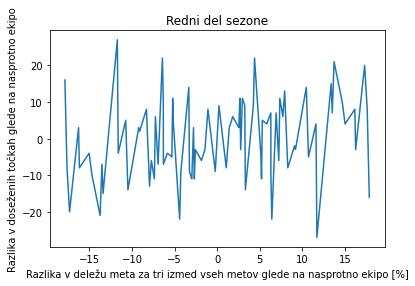

In [394]:
priblizno_enakovredne_tekme.groupby("3PA/FGA DIFF")["PTS DIFF"].mean().plot(title="Redni del sezone", xlabel="Razlika v deležu meta za tri izmed vseh metov glede na nasprotno ekipo [%]", ylabel="Razlika v doseženih točkah glede na nasprotno ekipo")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Razlika v deležu meta za tri izmed vseh metov glede na nasprotno ekipo [%]', ylabel='Razlika v doseženih točkah glede na nasprotno ekipo'>

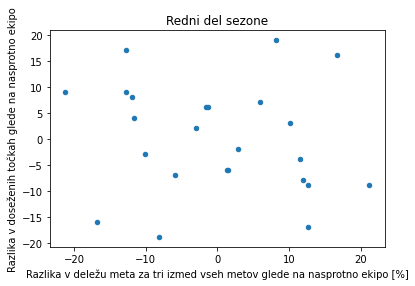

In [395]:
priblizno_enakovredne_tekme = tekme_redne2[(abs(tekme_redne2["3P% DIFF"]) < 2) & ((tekme_redne2["3P% AVG"] >= 45) & (tekme_redne2["3P% AVG"] <= 50))]
priblizno_enakovredne_tekme.plot.scatter("3PA/FGA DIFF","PTS DIFF",title="Redni del sezone", xlabel="Razlika v deležu meta za tri izmed vseh metov glede na nasprotno ekipo [%]", ylabel="Razlika v doseženih točkah glede na nasprotno ekipo")

<AxesSubplot:title={'center':'Redni del sezone'}, xlabel='Razlika v deležu meta za tri izmed vseh metov glede na nasprotno ekipo [%]', ylabel='Razlika v doseženih točkah glede na nasprotno ekipo'>

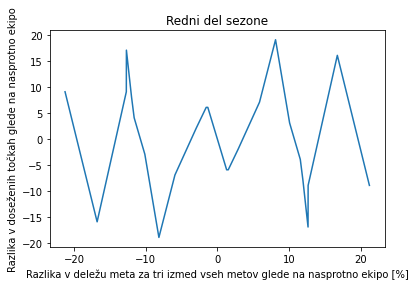

In [396]:
priblizno_enakovredne_tekme.groupby("3PA/FGA DIFF")["PTS DIFF"].mean().plot(title="Redni del sezone", xlabel="Razlika v deležu meta za tri izmed vseh metov glede na nasprotno ekipo [%]", ylabel="Razlika v doseženih točkah glede na nasprotno ekipo")

Torej je število metov za tri pomembno le, če ekipe slabo mečejo za tri, in tedaj je, logično, boljše za takšne ekipe, da čim manj mečejo za tri.